### DECISION TREE CLASSIFIER
In this assignment we will try to predict whether a vehicle is deemed accpetable or unacceptable depending upon factors such as maintenance, number of doors, safety, etc.

In [31]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

# Define constants
COUNT_THRESHOLD = 5  # Count threshold for labeling a node as a leaf
MAX_DEPTH = 3  # Maximum depth for the decision tree


In [32]:
# Function 1: Calculate Gini Impurity
def calculate_gini(data):
    """
    Calculates the Gini impurity for a given dataset.
    Gini Impurity is a metric used to measure how "pure" a dataset is.
    - A pure dataset (all labels are the same) has Gini = 0.
    - A completely heterogeneous dataset has Gini close to 1.
    Formula:
        Gini = 1 - Σ(p_i^2)  for all labels i
        where p_i is the proportion of rows with label i.
    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.
    Returns:
        A float representing the Gini impurity.
    """
    label_counts = {}
    for row in data:
        label = row[-1]
        label_counts[label] = label_counts.get(label, 0) + 1

    total = len(data)
    gini = 1.0
    for count in label_counts.values():
        prob = count / total
        gini -= prob ** 2
    return gini


In [33]:
# Function 2: Split dataset by an attribute
def split_data(data, attribute_index, value):
    """
    Splits the dataset into a subset based on the value of a specified attribute.
    Args:
        data: A list of rows. Each row is a list of attribute values.
        attribute_index: The index of the attribute to split on.
        value: The value of the attribute to match.
    Returns:
        A subset of the dataset where rows have the attribute at attribute_index equal to value.
    """
    return [row for row in data if row[attribute_index] == value]


In [34]:
# Function 3: Calculate Gini Gain
def gini_gain(data, attribute_index):
    """
    Calculates the Gini gain for a specific attribute.
    Gini Gain measures how much Gini impurity decreases when splitting the dataset
    on a specific attribute. The higher the gain, the better the attribute is for splitting.
    Formula:
        Gini Gain = Gini(parent) - Σ(weighted Gini(child subsets))
    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.
        attribute_index: The index of the attribute to evaluate.
    Returns:
        A float representing the Gini gain for the attribute.
    """
    parent_gini = calculate_gini(data)
    total = len(data)

    values = set(row[attribute_index] for row in data)
    weighted_gini = 0.0

    for value in values:
        subset = split_data(data, attribute_index, value)
        weight = len(subset) / total
        weighted_gini += weight * calculate_gini(subset)

    return parent_gini - weighted_gini


In [35]:
# Function 4: Build the Decision Tree
def build_tree(data, attributes, depth=0):
    """
    Recursively builds a decision tree using Gini impurity to find the best splits.
    Stopping conditions:
    1. No attributes left to split on.
    2. Depth exceeds MAX_DEPTH.
    3. Number of elements in a leaf is less than COUNT_THRESHOLD.
    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.
        attributes: A list of indices representing the available attributes for splitting.
    Returns:
        A dictionary representing the decision tree.
    """
    # Count labels
    labels = [row[-1] for row in data]
    majority_label = max(set(labels), key=labels.count)

    # Stopping conditions
    if len(set(labels)) == 1:
        return labels[0]
    if depth >= MAX_DEPTH or len(data) < COUNT_THRESHOLD or not attributes:
        return majority_label

    # Find best attribute
    best_attr = max(attributes, key=lambda i: gini_gain(data, i))

    tree = {best_attr: {}}
    values = set(row[best_attr] for row in data)

    for value in values:
        subset = split_data(data, best_attr, value)
        if not subset:
            tree[best_attr][value] = majority_label
        else:
            remaining_attrs = [i for i in attributes if i != best_attr]
            subtree = build_tree(subset, remaining_attrs, depth + 1)
            tree[best_attr][value] = subtree

    return tree


In [36]:
# Function 5: Predict a Single Instance
def predict(tree, instance):
    """
    Predicts the label for a single instance using the decision tree.
    Args:
        tree: The decision tree (dictionary).
        instance: A dictionary where keys are attribute indices and values are the instance's attribute values.
    Returns:
        The predicted label for the instance.
    """
    while isinstance(tree, dict):
        attribute = next(iter(tree))
        value = instance.get(attribute)
        tree = tree.get(attribute, {}).get(value)
        if tree is None:
            return None
    return tree


In [37]:
# Load the dataset from the CSV file
df = pd.read_csv("car_evaluation.csv")

# Define a mapping for the categorical values to numerical values
value_mappings = {
    'buying': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'maint': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

# Apply the mappings to the dataset
for column, mapping in value_mappings.items():
    df[column] = df[column].map(mapping)

# Extract the features and target
X = df.drop(columns=['class'])  # Drop the target column
y = df['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})  # Map target to numerical values

# Convert DataFrame to list for the decision tree
data = df.values.tolist()
attributes = list(range(len(X.columns)))  # Indexes of the attributes (buying, maint, etc.)
attribute_names = list(X.columns)  # Get the actual attribute names

# Build the decision tree
tree = build_tree(data, attributes)
print("Decision Tree:", tree)


Decision Tree: {5: {0: 'unacc', 1: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'unacc', 3: 'unacc'}}, 2: {4: {0: 'unacc', 1: 'acc', 2: 'acc'}}}}, 2: {3: {0: 'unacc', 1: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'acc'}}, 2: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}}}}}


In [38]:
# Visualize the decision tree
def plot_tree(tree, depth=0, x_offset=0.5, y_offset=1.0, x_gap=0.25, ax=None, data=None, attribute_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')  # Turn off the axes

    # If the tree is a leaf node, plot the label and counts
    if not isinstance(tree, dict):
        label_counts = {label: sum(1 for row in data if row[-1] == label) for label in set(row[-1] for row in data)}
        label_text = f"{tree}\n" + "\n".join([f"{label}: {count}" for label, count in label_counts.items()])
        ax.text(x_offset, y_offset, label_text, fontsize=10, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", edgecolor="black"))
        return

    # Get the current decision attribute name
    root = list(tree.keys())[0]
    attribute_name = attribute_names[root]  # Map the index to the attribute name
    ax.text(x_offset, y_offset, f"{attribute_name}", fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", edgecolor="black"))

    # Recursively plot child nodes
    num_children = len(tree[root])
    for i, (value, subtree) in enumerate(tree[root].items()):
        child_x = x_offset + (i - (num_children - 1) / 2) * x_gap
        child_y = y_offset - 0.1
        ax.plot([x_offset, child_x], [y_offset - 0.02, child_y + 0.02], 'k-', lw=1)
        subset = split_data(data, root, value)
        plot_tree(subtree, depth + 1, child_x, child_y, x_gap / 2, ax=ax, data=subset, attribute_names=attribute_names)

    if depth == 0:
        plt.show()


<Figure size 1400x800 with 0 Axes>

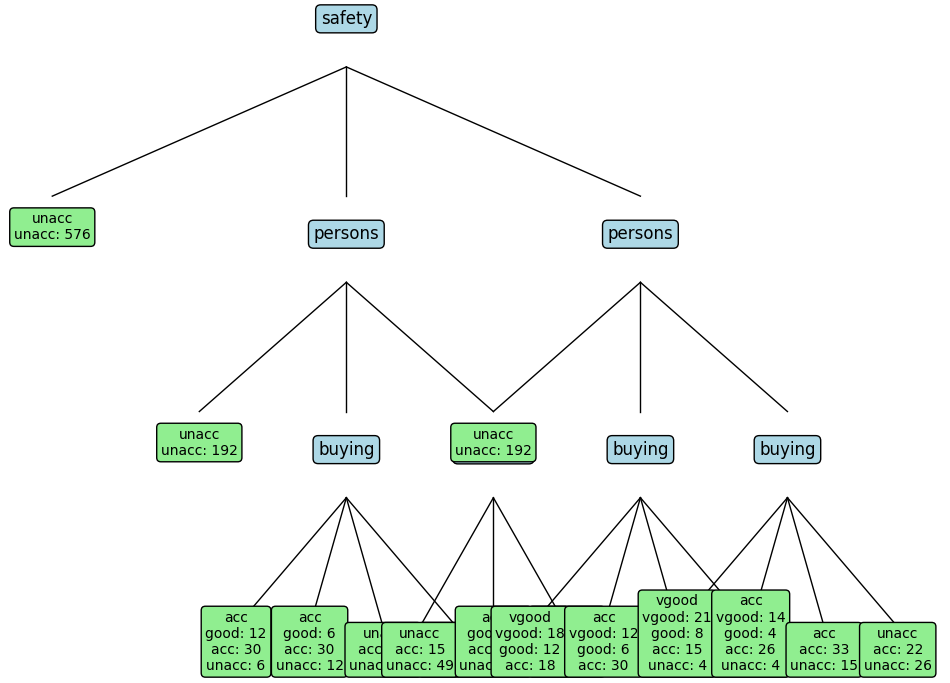

In [39]:
# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)
